In [1]:
# Imports relativos ao sistema operacional
import os
import sys

In [2]:
# Passagem de caminhos do Spark e do diretório de dados
SPARK_PATH = "/Users/flavio.clesio/Documents/spark-2.1.0" 
ROOT_DIR = "/Users/flavio.clesio/Downloads/machine-learning-with-spark-code/data/bike-sharing/Bike-Sharing-Dataset"

In [3]:
# Neste snippet passamos os caminhos do Spark como variaveis de ambiente para o sistema operacional
os.environ['SPARK_HOME'] = SPARK_PATH
os.environ['HADOOP_HOME'] = SPARK_PATH

# Neste snippet passamos todas as partes da instalacao do Spark
sys.path.append(SPARK_PATH + "/bin")
sys.path.append(SPARK_PATH + "/python")
sys.path.append(SPARK_PATH + "/python/pyspark/")
sys.path.append(SPARK_PATH + "/python/lib")
sys.path.append(SPARK_PATH + "/python/lib/pyspark.zip")
sys.path.append(SPARK_PATH + "/python/lib/py4j-0.10.4-src.zip") # Must be the same version of your Spark Version

In [154]:
%matplotlib inline

In [155]:
# Vamos fazer agora alguns imports iniciais em relação ao Spark
from pyspark import SparkContext
from pyspark import SparkConf
from pyspark.mllib.tree import DecisionTree, DecisionTreeModel
from pyspark.mllib.util import MLUtils
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.regression import LinearRegressionWithSGD
from pyspark.mllib.tree import DecisionTree
import matplotlib.pyplot
import numpy as np
import matplotlib
matplotlib.use('Agg')

In [156]:
%pylab inline
pylab.rcParams['figure.figsize'] = (14, 9)

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['pylab', 'test']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [5]:
# Instanciamento da sessao do Spark
sc = SparkContext("local", "app-regressao-pyspark")
sc

# Extracao de features para o modelo linear

Paper: Fanaee-T, Hadi and Gama Joao, Event labeling combining ensemble detectors and background knowledge, Progress in Artificial Intelligence, pp.1-15, Springer Berlin Heidelberg, 2013.  

Paper original: http://link.springer.com/article/10.1007%2Fs13748-013-0040-3.

Descricao das variaveis:

• instant: Chave da transacao  
• dteday: Data  
• season: Estacao do ano  
• yr: Ano  
• mnth: Mes do ano  
• hr: Hora do ano  
• holiday: Se e feriado ou nao  
• weekday: Qual o dia da semana  
• workingday: Se e dia util ou nao  
• weathersit: Descricao do tempo  
• temp: Temperatura normalizada  
• atemp: Temperatura aparente  
• hum: Umidade aparente  
• windspeed: Velocidade do vento normalizada  
• cnt: Variavel target com o numero de bikes alugadas na respectiva hora

In [12]:
# Carga do arquivo .csv
raw_data = sc.textFile(ROOT_DIR + "/hour_noheader.csv")

In [18]:
# Contagem simples em relacao ao numero de registros
num_data = raw_data.count()
print 'Quantidade de registros:',  num_data

Quantidade de registros: 17379


In [14]:
# Transformacao do arquivo em um RDD realizando a divisao pela virgula
records = raw_data.map(lambda x: x.split(","))

In [15]:
# Primeiro registro ja sem os headers
first = records.first()
print first

[u'1', u'2011-01-01', u'1', u'0', u'1', u'0', u'0', u'6', u'0', u'1', u'0.24', u'0.2879', u'0.81', u'0', u'3', u'13', u'16']


In [16]:
# Vamos colocar os dados em cache, ja que vamos realizar inumeras leituras
records.cache()

PythonRDD[10] at RDD at PythonRDD.scala:48

In [19]:
# A funcao abaixo ira realizar o map no rdd passado como parametro, e aplicando a funcao lambda nos campos pegando
# cada valor do seu indice fields[idx] e nao somente isso ira pegar os registros distintos de cada campo .distinct()
# e cada elmento sera indexado de acordo com a sua aparicao usando o .zipWithIndex() e por no final o .collectAsMap()
# vai retornar o valor pareado via chave-valor

def get_mapping(rdd, idx):
    return rdd.map(lambda fields: fields[idx]).distinct().zipWithIndex().collectAsMap()

In [27]:
print "Mapeamento da primeira coluna categorica: %s" % get_mapping(records, 2)

Mapeamento da primeira coluna categorica: {u'1': 0, u'3': 1, u'2': 2, u'4': 3}


In [ ]:
# Agora o mapeamento sera feito para as variaveis da 2 ate a 10 de forma incremental e sera armazenada no objeto 
# mappings
mappings = [get_mapping(records, i) for i in range(2,10)]

In [30]:
# Mapeamentos para cada uma das variaveis (Por ordem)
mappings

[{u'1': 0, u'2': 2, u'3': 1, u'4': 3},
 {u'0': 1, u'1': 0},
 {u'1': 3,
  u'10': 1,
  u'11': 0,
  u'12': 2,
  u'2': 5,
  u'3': 4,
  u'4': 7,
  u'5': 6,
  u'6': 9,
  u'7': 8,
  u'8': 11,
  u'9': 10},
 {u'0': 5,
  u'1': 4,
  u'10': 15,
  u'11': 14,
  u'12': 17,
  u'13': 16,
  u'14': 19,
  u'15': 18,
  u'16': 21,
  u'17': 20,
  u'18': 23,
  u'19': 22,
  u'2': 7,
  u'20': 0,
  u'21': 1,
  u'22': 2,
  u'23': 3,
  u'3': 6,
  u'4': 9,
  u'5': 8,
  u'6': 11,
  u'7': 10,
  u'8': 13,
  u'9': 12},
 {u'0': 1, u'1': 0},
 {u'0': 1, u'1': 0, u'2': 3, u'3': 2, u'4': 5, u'5': 4, u'6': 6},
 {u'0': 1, u'1': 0},
 {u'1': 0, u'2': 2, u'3': 1, u'4': 3}]

In [32]:
# Aqui vamos fazer a soma de quantas categorias diferentes apareceram
cat_len = sum(map(len, mappings))
print 'Numero de categorias distintas das variaveis categoricas:',  cat_len

Numero de categorias distintas das variaveis categoricas: 57


In [38]:
# Primeiro registro das colunas 11 até a 15
records.first()[11:15]

[u'0.2879', u'0.81', u'0', u'3']

In [39]:
# Primeiro registro do dataset records
records.first()

[u'1',
 u'2011-01-01',
 u'1',
 u'0',
 u'1',
 u'0',
 u'0',
 u'6',
 u'0',
 u'1',
 u'0.24',
 u'0.2879',
 u'0.81',
 u'0',
 u'3',
 u'13',
 u'16']

In [40]:
# Tamanho das variaveis numericas
num_len = len(records.first()[11:15])
print 'Quantidade de variaveis numericas:', num_len

Quantidade de variaveis numericas: 4


In [41]:
total_len = num_len + cat_len

In [45]:
print "Tamanho do vetor de features (Feature vector) das variaveis categoricas: %d" % cat_len

Tamanho do vetor de features (Feature vector) das variaveis categoricas: 57


In [46]:
print "Tamanho do vetor de features (Feature vector) das variaveis numericas: %d" % num_len

Tamanho do vetor de features (Feature vector) das variaveis numericas: 4


In [47]:
print "Tamanho total do vetor de features: %d" % total_len

Tamanho total do vetor de features: 61


# Criando vetor de features para o modelo linear

No caso vamos pegar os mappings que foram extraidos anteriormente das variaveis categoricas, e vamos transformar em variaveis binarias.  

No caso a funcao abaixo vai aplicar esse binary-encoding para todas as instancias da base de dados.  

Tambem sera criada uma funcao para extrair a variavel target de cada registro.  

O import da classe LabeledPoint vai construir os vetores de features e as variaveis target.

In [49]:
# A funcao passa por cada coluna do dataset e faz a extracao do encoding binario de cada uma das variaveis. A variavei
# step garante que uma feature nao-zero sera acrescida ao vetor de features. A vetor numerico sera criado primeiramente
# convertendo os dados para ponto flutuante e guardar esse numero em um array do numpy

def extract_features(record):
    cat_vec = np.zeros(cat_len)
    i = 0
    step = 0
    for field in record[2:9]:
        m = mappings[i]
        idx = m[field]
        cat_vec[idx + step] = 1
        i = i + 1
    step = step + len(m)
    num_vec = np.array([float(field) for field in record[10:14]])
    return np.concatenate((cat_vec, num_vec))

In [50]:
# Essa funcao simplesmente converte a ultima coluna da variavel (um count) em um float
def extract_label(record):
    return float(record[-1])

In [52]:
# Usando o metodo .map vamos passar as duas funcoes no dataset records para gerar a base data
data = records.map(lambda r: LabeledPoint(extract_label(r), extract_features(r)))

In [55]:
data.take(3)

[LabeledPoint(16.0, [1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.24,0.2879,0.81,0.0]),
 LabeledPoint(40.0, [1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.22,0.2727,0.8,0.0]),
 LabeledPoint(32.0, [1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.22,0.2727,0.8,0.0])]

In [56]:
first_point = data.first()

In [57]:
print "Raw data: " + str(first[2:])

Raw data: [u'1', u'0', u'1', u'0', u'0', u'6', u'0', u'1', u'0.24', u'0.2879', u'0.81', u'0', u'3', u'13', u'16']


In [58]:
print "Label: " + str(first_point.label)

Label: 16.0


In [59]:
print "Linear Model feature vector:\n" + str(first_point.features)

Linear Model feature vector:
[1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.24,0.2879,0.81,0.0]


In [60]:
print "Linear Model feature vector length: " + str(len(first_point.features))

Linear Model feature vector length: 61


# Criacao do vetor de features para o modelo de arvore de decisao

In [61]:
# Funcao para extracao de features para o modelo de arvore de decisao regressora
def extract_features_dt(record):
    return np.array(map(float, record[2:14]))

In [62]:
# Transformacao em labelpoint realizando a extracao do label e das features
data_dt = records.map(lambda r: LabeledPoint(extract_label(r),extract_features_dt(r)))

In [69]:
first_point_dt = data_dt.first()

In [70]:
print "Decision Tree feature vector: " + str(first_point_dt.features)

Decision Tree feature vector: [1.0,0.0,1.0,0.0,0.0,6.0,0.0,1.0,0.24,0.2879,0.81,0.0]


In [71]:
print "Decision Tree feature vector length: " + str(len(first_point_dt.features))

Decision Tree feature vector length: 12


# Parametros de cada modelo

In [67]:
# Paarmetros do modelo linear com SGD
help(LinearRegressionWithSGD.train)

Help on method train in module pyspark.mllib.regression:

train(cls, data, iterations=100, step=1.0, miniBatchFraction=1.0, initialWeights=None, regParam=0.0, regType=None, intercept=False, validateData=True, convergenceTol=0.001) method of __builtin__.type instance
    Train a linear regression model using Stochastic Gradient
    Descent (SGD). This solves the least squares regression
    formulation
    
        f(weights) = 1/(2n) ||A weights - y||^2
    
    which is the mean squared error. Here the data matrix has n rows,
    and the input RDD holds the set of rows of A, each with its
    corresponding right hand side label y.
    See also the documentation for the precise formulation.
    
    :param data:
      The training data, an RDD of LabeledPoint.
    :param iterations:
      The number of iterations.
      (default: 100)
    :param step:
      The step parameter used in SGD.
      (default: 1.0)
    :param miniBatchFraction:
      Fraction of data to be used for each SGD 

In [68]:
# Paarmetros do modelo linear com arvore de decisao regressora
help(DecisionTree.trainRegressor)

Help on method trainRegressor in module pyspark.mllib.tree:

trainRegressor(cls, data, categoricalFeaturesInfo, impurity='variance', maxDepth=5, maxBins=32, minInstancesPerNode=1, minInfoGain=0.0) method of __builtin__.type instance
    Train a decision tree model for regression.
    
    :param data:
      Training data: RDD of LabeledPoint. Labels are real numbers.
    :param categoricalFeaturesInfo:
      Map storing arity of categorical features. An entry (n -> k)
      indicates that feature n is categorical with k categories
      indexed from 0: {0, 1, ..., k-1}.
    :param impurity:
      Criterion used for information gain calculation.
      The only supported value for regression is "variance".
      (default: "variance")
    :param maxDepth:
      Maximum depth of tree (e.g. depth 0 means 1 leaf node, depth 1
      means 1 internal node + 2 leaf nodes).
      (default: 5)
    :param maxBins:
      Number of bins used for finding splits at each node.
      (default: 32)
    :

# Treinamento do modelo linear

In [74]:
linear_model = LinearRegressionWithSGD.train(data
                                             ,iterations=10
                                             ,step=0.1
                                             ,intercept=False)

In [75]:
# Aqui vamos usar o .map para o nosso conjunto de dados data, e usando a funcao lambda vamos pegar a coluna com os valores
# que no caso é o p.label e o resultado das predicoes no .peatures
true_vs_predicted = data.map(lambda p: (p.label, linear_model.predict(p.features)))

In [76]:
print "Linear Model predictions: " + str(true_vs_predicted.take(5))

Linear Model predictions: [(16.0, 160.01234799867828), (40.0, 159.785197748266), (32.0, 153.93103032000286), (13.0, 151.31181935148854), (1.0, 155.54992134607073)]


In [77]:
# Agora vamos usar o regressor da arvore de decisao regressora. No caso quando se a algum tipo de variavel categorica
# e necessario passar como argumento categoricalFeaturesInfo. No caso vai ficar as...is
dt_model = DecisionTree.trainRegressor(data_dt
                                       ,{})

# A diferenca fundamental que precisa ser enendida e que no modelo linear, obrigatoriamente as variavels dummy precisam
# estar criadas no vetor de features, enquanto no modelo de arvore de decisao, como o algoritmo tem propriedades
# de quebra da arvore, nem sempre isso e necessario, mas e recomendado

In [78]:
preds = dt_model.predict(data_dt.map(lambda p: p.features))

In [79]:
actual = data.map(lambda p: p.label)

In [80]:
true_vs_predicted_dt = actual.zip(preds)

In [81]:
print "Decision Tree predictions: " + str(true_vs_predicted_dt.take(5))

Decision Tree predictions: [(16.0, 54.913223140495866), (40.0, 54.913223140495866), (32.0, 53.171052631578945), (13.0, 14.284023668639053), (1.0, 14.284023668639053)]


In [82]:
print "Decision Tree depth: " + str(dt_model.depth())

Decision Tree depth: 5


In [83]:
print "Decision Tree number of nodes: " + str(dt_model.numNodes())

Decision Tree number of nodes: 63


# Avaliacao dos modelos

In [90]:
# Para a avaliacao dos modelos regresores, geralmente usa-se as medidas de erro MSE (Mean Square Error), 
# MAE (Mean Absolute Error), RMSE (Root Mean Square Error) em que RMSLE (Root Mean Squared Log Error):

# MSE: Media do erro quadratico que e usado na funcao de perda da regressao. Penaliza de forma mais agressiva os erros mais extremos
# RMSE: Raiz quadrada do MSE. E medido na mesma escala da variavel
# MAE: Media da diferenca absoluta entre as predicoes
# RMSLE: E a transformacao do RMSE e deve ser usada quando o range de predicao for grande, e nao se quer penalizar
#        os grandes erros. Isso e efetivo quando se quer ter o maximo de acertos em % ao inves da diferenca dos erros em si

def squared_error(actual, pred):
    return (pred - actual)**2

def abs_error(actual, pred):
    return np.abs(pred - actual)

def squared_log_error(pred, actual):
    return (np.log(pred + 1) - np.log(actual + 1))**2

In [91]:
mse = true_vs_predicted.map(lambda (t, p): squared_error(t, p)).mean()
mae = true_vs_predicted.map(lambda (t, p): abs_error(t, p)).mean()
rmsle = np.sqrt(true_vs_predicted.map(lambda (t, p): squared_log_error(t, p)).mean())

In [92]:
print "Linear Model - Mean Squared Error: %2.4f" % mse
print "Linear Model - Mean Absolute Error: %2.4f" % mae
print "Linear Model - Root Mean Squared Log Error: %2.4f" % rmsle

Linear Model - Mean Squared Error: 32862.9488
Linear Model - Mean Absolute Error: 136.3712
Linear Model - Root Mean Squared Log Error: 1.4951


In [93]:
mse_dt = true_vs_predicted_dt.map(lambda (t, p): squared_error(t, p)).mean()
mae_dt = true_vs_predicted_dt.map(lambda (t, p): abs_error(t, p)).mean()
rmsle_dt = np.sqrt(true_vs_predicted_dt.map(lambda (t, p): squared_log_error(t, p)).mean())

In [94]:
print "Decision Tree - Mean Squared Error: %2.4f" % mse_dt
print "Decision Tree - Mean Absolute Error: %2.4f" % mae_dt
print "Decision Tree - Root Mean Squared Log Error: %2.4f" % rmsle_dt

Decision Tree - Mean Squared Error: 11560.7978
Decision Tree - Mean Absolute Error: 71.0969
Decision Tree - Root Mean Squared Log Error: 0.6259


# Tunning do modelo

In [99]:
import pylab
%pylab 

Using matplotlib backend: agg
Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['pylab']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [100]:
targets = records.map(lambda r: float(r[-1])).collect()

In [104]:
hist(targets, bins=40, color='lightblue', normed=True)

(array([  7.96372860e-03,   3.40527809e-03,   2.69781034e-03,
          2.37473340e-03,   2.27568792e-03,   2.24503098e-03,
          2.12240324e-03,   2.09410453e-03,   1.80875921e-03,
          1.71207195e-03,   1.37720388e-03,   1.37248743e-03,
          1.23099388e-03,   9.64514361e-04,   8.53677747e-04,
          8.65468877e-04,   6.83885488e-04,   5.94272907e-04,
          5.70690649e-04,   4.78719842e-04,   5.02302100e-04,
          3.72599680e-04,   3.49017422e-04,   3.39584518e-04,
          2.52330163e-04,   2.26389679e-04,   2.02807421e-04,
          1.88658066e-04,   1.50926453e-04,   1.29702420e-04,
          9.90454845e-05,   6.36720972e-05,   8.72543554e-05,
          1.01403710e-04,   8.25379038e-05,   5.65974197e-05,
          4.71645164e-05,   1.17911291e-05,   9.43290329e-06,
          1.88658066e-05]),
 array([   1. ,   25.4,   49.8,   74.2,   98.6,  123. ,  147.4,  171.8,
         196.2,  220.6,  245. ,  269.4,  293.8,  318.2,  342.6,  367. ,
         391.4,  415.8

In [105]:
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(16, 10)

In [106]:
# Devido ao fato de que a distribuicao nao e uniformemente distribuida, no caso temos que transformar os dados para
# logaritmo
log_targets = records.map(lambda r: np.log(float(r[-1]))).collect()

In [107]:
hist(log_targets, bins=40, color='lightblue', normed=True)

(array([ 0.05282272,  0.        ,  0.        ,  0.        ,  0.06953877,
         0.        ,  0.0748879 ,  0.        ,  0.07722815,  0.08692346,
         0.07889975,  0.06619556,  0.10363951,  0.10096494,  0.07856543,
         0.0621837 ,  0.0956158 ,  0.10497679,  0.1066484 ,  0.1210242 ,
         0.12871358,  0.12135852,  0.13172247,  0.15245037,  0.16649185,
         0.19190025,  0.23235309,  0.26545087,  0.30122321,  0.3376642 ,
         0.38012297,  0.39516741,  0.36842173,  0.3423447 ,  0.30824395,
         0.24472297,  0.20661037,  0.14275506,  0.07689383,  0.03543803]),
 array([ 0.        ,  0.17211217,  0.34422433,  0.5163365 ,  0.68844867,
         0.86056083,  1.032673  ,  1.20478516,  1.37689733,  1.5490095 ,
         1.72112166,  1.89323383,  2.065346  ,  2.23745816,  2.40957033,
         2.58168249,  2.75379466,  2.92590683,  3.09801899,  3.27013116,
         3.44224333,  3.61435549,  3.78646766,  3.95857982,  4.13069199,
         4.30280416,  4.47491632,  4.64702849,  4

In [108]:
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(16, 10)

In [109]:
# Quando nao houver valores negativos e o range de valores for bem alto, recomenda-se a transformacao via raiz quadrada
sqrt_targets = records.map(lambda r: np.sqrt(float(r[-1]))).collect()

In [110]:
hist(sqrt_targets, bins=40, color='lightblue', normed=True)

(array([ 0.04488088,  0.05530237,  0.05043394,  0.05119463,  0.0376543 ,
         0.04609799,  0.04297915,  0.03818678,  0.03887141,  0.04510909,
         0.04001245,  0.04746724,  0.04982538,  0.05073822,  0.05203139,
         0.05385706,  0.05781266,  0.0512707 ,  0.05553058,  0.04564157,
         0.04609799,  0.04214239,  0.03818678,  0.03149269,  0.03217731,
         0.02852598,  0.0222883 ,  0.02198402,  0.02122333,  0.01589848,
         0.01597455,  0.01080184,  0.00988901,  0.00882404,  0.00585734,
         0.00425988,  0.00547699,  0.00342312,  0.00167352,  0.00091283]),
 array([  1.        ,   1.75642498,   2.51284996,   3.26927494,
          4.02569992,   4.7821249 ,   5.53854988,   6.29497486,
          7.05139984,   7.80782482,   8.5642498 ,   9.32067478,
         10.07709976,  10.83352475,  11.58994973,  12.34637471,
         13.10279969,  13.85922467,  14.61564965,  15.37207463,
         16.12849961,  16.88492459,  17.64134957,  18.39777455,
         19.15419953,  19.9106

In [111]:
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(16, 10)

# Impacto das transformacoes de log e raiz no treinamento

In [112]:
data_log = data.map(lambda lp: LabeledPoint(np.log(lp.label),lp.features))

In [113]:
model_log = LinearRegressionWithSGD.train(data_log
                                          ,iterations=10
                                          ,step=0.1)

In [114]:
true_vs_predicted_log = data_log.map(lambda p: (np.exp(p.label),np.exp(model_log.predict(p.features))))

In [115]:
mse_log = true_vs_predicted_log.map(lambda (t, p): squared_error(t,p)).mean()
mae_log = true_vs_predicted_log.map(lambda (t, p): abs_error(t, p)).mean()
rmsle_log = np.sqrt(true_vs_predicted_log.map(lambda (t, p): squared_log_error(t, p)).mean())

In [116]:
print "Mean Squared Error: %2.4f" % mse_log
print "Mean Absolue Error: %2.4f" % mae_log
print "Root Mean Squared Log Error: %2.4f" % rmsle_log
print "Non log-transformed predictions:\n" + str(true_vs_predicted.take(3))
print "Log-transformed predictions:\n" + str(true_vs_predicted_log.take(3))

Mean Squared Error: 52254.3669
Mean Absolue Error: 158.3636
Root Mean Squared Log Error: 1.6345
Non log-transformed predictions:
[(16.0, 160.01234799867828), (40.0, 159.785197748266), (32.0, 153.93103032000286)]
Log-transformed predictions:
[(15.999999999999998, 53.284234677508636), (40.0, 52.055113205629205), (32.0, 44.608309612091546)]


In [117]:
data_dt_log = data_dt.map(lambda lp:LabeledPoint(np.log(lp.label), lp.features))
dt_model_log = DecisionTree.trainRegressor(data_dt_log,{})
preds_log = dt_model_log.predict(data_dt_log.map(lambda p:p.features))
actual_log = data_dt_log.map(lambda p: p.label)
true_vs_predicted_dt_log = actual_log.zip(preds_log).map(lambda (t,p): (np.exp(t), np.exp(p)))
mse_log_dt = true_vs_predicted_dt_log.map(lambda (t, p): squared_error(t, p)).mean()
mae_log_dt = true_vs_predicted_dt_log.map(lambda (t, p): abs_error(t,p)).mean()
rmsle_log_dt = np.sqrt(true_vs_predicted_dt_log.map(lambda (t, p):squared_log_error(t, p)).mean())

In [118]:
print "Mean Squared Error: %2.4f" % mse_log_dt
print "Mean Absolue Error: %2.4f" % mae_log_dt
print "Root Mean Squared Log Error: %2.4f" % rmsle_log_dt
print "Non log-transformed predictions:\n" + str(true_vs_predicted_dt.take(3))
print "Log-transformed predictions:\n" + str(true_vs_predicted_dt_log.take(3))

Mean Squared Error: 14781.5760
Mean Absolue Error: 76.4131
Root Mean Squared Log Error: 0.6406
Non log-transformed predictions:
[(16.0, 54.913223140495866), (40.0, 54.913223140495866), (32.0, 53.171052631578945)]
Log-transformed predictions:
[(15.999999999999998, 37.530779787154508), (40.0, 37.530779787154508), (32.0, 7.2797070993907127)]


# Tunning do modelo 

In [119]:
# Atribuicao de index para todos os campos via chave e valor
data_with_idx = data.zipWithIndex().map(lambda (k, v): (v, k))

In [120]:
# Nesse caso a base de teste sera criada usando 20% de todo o conjunto de dados
test = data_with_idx.sample(False, 0.2, 42)

In [121]:
# O subtractByKey() faz o trabalho de remover da base inicial as instancias que tem overlap
# ou seja, esses serao os 80% da base de testes
train = data_with_idx.subtractByKey(test)

In [123]:
train_data = train.map(lambda (idx, p): p)
test_data = test.map(lambda (idx, p) : p)
train_size = train_data.count()
test_size = test_data.count()

In [124]:
print "Training data size: %d" % train_size
print "Test data size: %d" % test_size
print "Total data size: %d " % num_data
print "Train + Test size : %d" % (train_size + test_size)

Training data size: 13843
Test data size: 3536
Total data size: 17379 
Train + Test size : 17379


In [125]:
data_with_idx_dt = data_dt.zipWithIndex().map(lambda (k, v): (v, k))
test_dt = data_with_idx_dt.sample(False, 0.2, 42)
train_dt = data_with_idx_dt.subtractByKey(test_dt)
train_data_dt = train_dt.map(lambda (idx, p): p)
test_data_dt = test_dt.map(lambda (idx, p) : p)

In [126]:
def evaluate(train, test, iterations, step, regParam, regType,intercept):
    model = LinearRegressionWithSGD.train(train
                                          ,iterations
                                          ,step
                                          ,regParam=regParam
                                          ,regType=regType
                                          ,intercept=intercept)
    
    tp = test.map(lambda p: (p.label, model.predict(p.features)))
    
    rmsle = np.sqrt(tp.map(lambda (t, p): squared_log_error(t, p)).mean())
    
    return rmsle

In [159]:
# Numero de interacoes como parametros
params = [1, 5, 10, 20, 50, 100]
metrics = [evaluate(train_data, test_data, param, 0.01, 0.0,'l2',False) for param in params]

print 'Parametros escolhidos:', params
print 'RMSLE dos parametros', metrics

Parametros escolhidos: [1, 5, 10, 20, 50, 100]
RMSLE dos parametros [2.938740007589578, 2.0916005231359911, 1.8212144102414591, 1.6176571449076043, 1.4562005099627713, 1.4101463900586928]


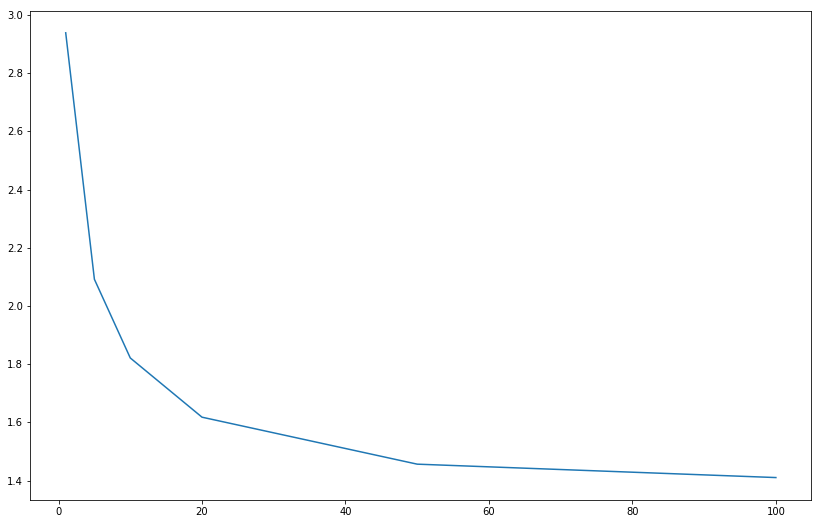

In [157]:
matplotlib.pyplot.plot(params, metrics)
matplotlib.pyplot.show()

In [161]:
# Step size
params = [0.01, 0.025, 0.05, 0.1, 1.0]
metrics = [evaluate(train_data, test_data, 10, param, 0.0, 'l2',False) for param in params]

print 'Parametros escolhidos:', params
print 'RMSLE dos parametros', metrics

Parametros escolhidos: [0.01, 0.025, 0.05, 0.1, 1.0]
RMSLE dos parametros [1.8212144102414591, 1.455621468985357, 1.4132303798228281, 1.4856410282121733, 1.4373432312660201]


In [163]:
# Regularizacao Ridge (L2)
params = [0.0, 0.01, 0.1, 1.0, 5.0, 10.0, 20.0]
metrics = [evaluate(train_data, test_data, 10, 0.1, param, 'l2',False) for param in params]

print 'Parametros escolhidos:', params
print 'RMSLE dos parametros', metrics

Parametros escolhidos: [0.0, 0.01, 0.1, 1.0, 5.0, 10.0, 20.0]
RMSLE dos parametros [1.4856410282121733, 1.4850439245172697, 1.479780052361904, 1.4376982988451119, 1.4256021549246309, 1.5702189463701444, 1.8751498160911304]


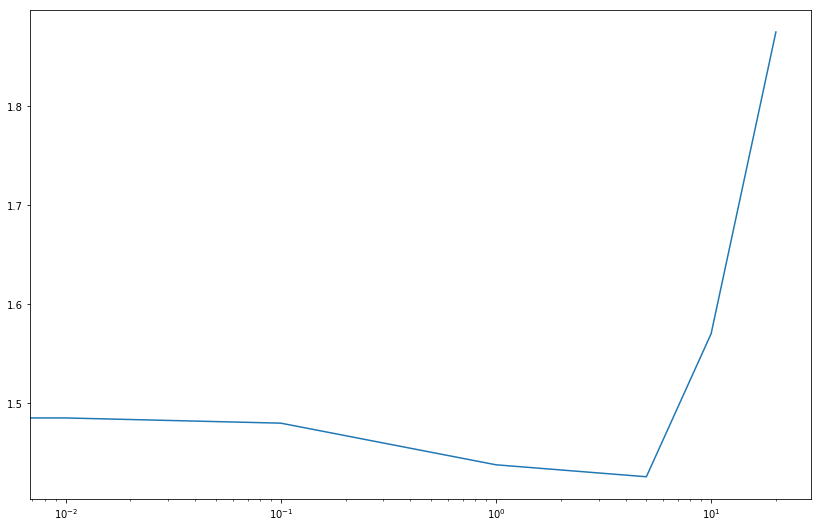

In [164]:
matplotlib.pyplot.plot(params, metrics)
matplotlib.pyplot.xscale('log')
matplotlib.pyplot.show()

In [168]:
# Regularizacao L! (Lasso)
params = [0.0, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
metrics = [evaluate(train_data, test_data, 10, 0.1, param, 'l1',False) for param in params]

print 'Parametros escolhidos:', params
print 'RMSLE dos parametros', metrics

Parametros escolhidos: [0.0, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
RMSLE dos parametros [1.4856410282121733, 1.4856114650997028, 1.4853455595021163, 1.4827028686828554, 1.4581581440974132, 1.5480780831167806, 4.7975574647546564]


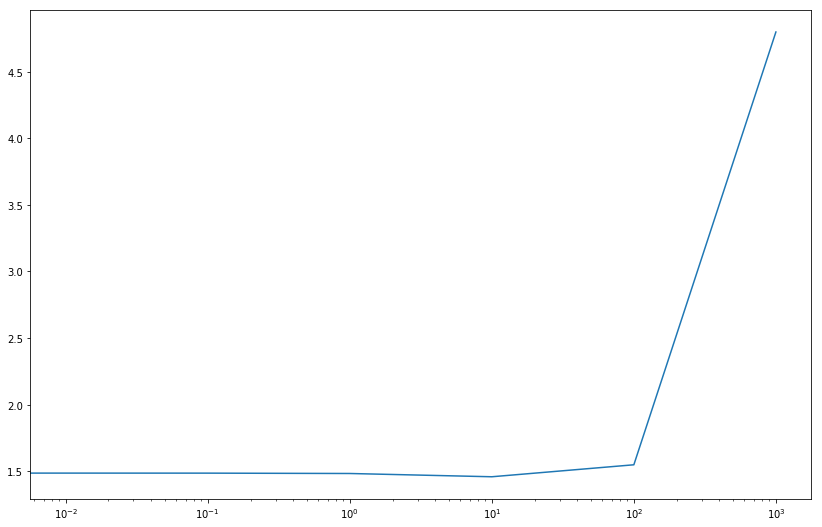

In [169]:
matplotlib.pyplot.plot(params, metrics)
matplotlib.pyplot.xscale('log')
matplotlib.pyplot.show()

In [167]:
model_l1 = LinearRegressionWithSGD.train(train_data, 10, 0.1,regParam=1.0, regType='l1', intercept=False)
model_l1_10 = LinearRegressionWithSGD.train(train_data, 10, 0.1,regParam=10.0, regType='l1', intercept=False)
model_l1_100 = LinearRegressionWithSGD.train(train_data, 10, 0.1,regParam=100.0, regType='l1', intercept=False)

In [170]:
print "L1 (1.0) number of zero weights: " + str(sum(model_l1.weights.array == 0))
print "L1 (10.0) number of zeros weights: " + str(sum(model_l1_10.weights.array == 0))
print "L1 (100.0) number of zeros weights: " + str(sum(model_l1_100.weights.array == 0))

L1 (1.0) number of zero weights: 33
L1 (10.0) number of zeros weights: 44
L1 (100.0) number of zeros weights: 59


In [ ]:
# Como a regularizacao e mais agressiva o numero de numeros zeros e maior quanto mais se aumenta a regularizacao

In [171]:
# Intercepto
params = [False, True]
metrics = [evaluate(train_data, test_data, 10, 0.1, 1.0, 'l2', param)for param in params]
print 'Parametros escolhidos:', params
print 'RMSLE dos parametros', metrics

Parametros escolhidos: [False, True]
RMSLE dos parametros [1.4376982988451119, 1.4619745637443835]


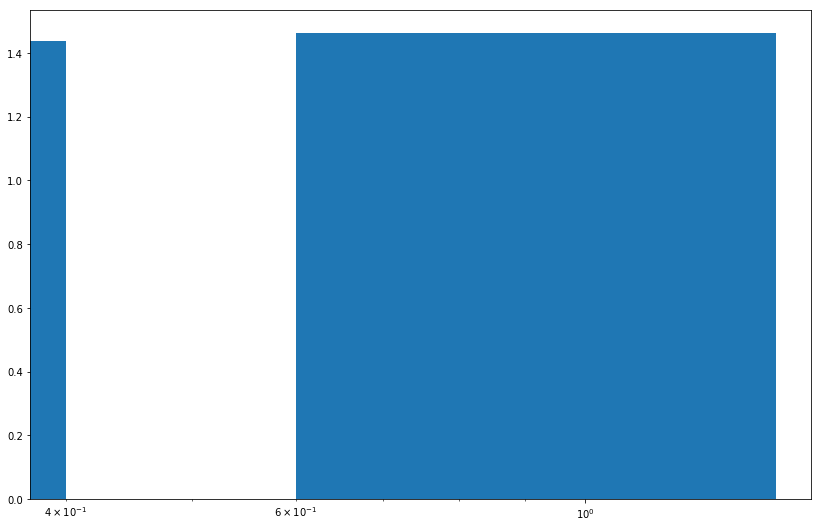

In [172]:
# Put in bar
matplotlib.pyplot.bar(params, metrics)
matplotlib.pyplot.xscale('log')
matplotlib.pyplot.show()

# Impacto dos parametros na arvore de decisao regressora

In [174]:
def evaluate_dt(train, test, maxDepth, maxBins):
    model = DecisionTree.trainRegressor(train
                                        , {}
                                        ,impurity='variance'
                                        ,maxDepth=maxDepth
                                        ,maxBins=maxBins)
    
    preds = model.predict(test.map(lambda p: p.features))
    
    actual = test.map(lambda p: p.label)
    
    tp = actual.zip(preds)
    
    rmsle = np.sqrt(tp.map(lambda (t, p): squared_log_error(t,p)).mean())
    
    return rmsle

[1, 2, 3, 4, 5, 10, 20]
[1.0096683340936519, 0.91969992278272761, 0.8153844681589919, 0.73662190225082969, 0.63743991277301437, 0.41268609723707311, 0.44150092501568089]


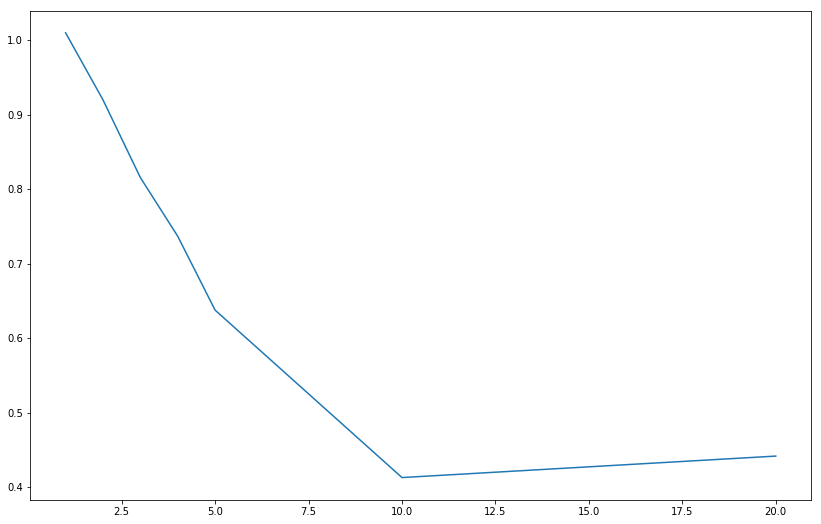

In [175]:
# Tree Depth
params = [1, 2, 3, 4, 5, 10, 20]
metrics = [evaluate_dt(train_data_dt, test_data_dt, param, 32) for param in params]

print 'Parametros escolhidos:', params
print 'RMSLE dos parametros', metrics

plot(params, metrics)
fig = matplotlib.pyplot.gcf()

Parametros escolhidos: [2, 4, 8, 16, 32, 64, 100]
RMSLE dos parametros [1.2571956557524344, 0.81163776220529393, 0.75846230141673943, 0.62020394014589464, 0.63743991277301437, 0.63743991277301437, 0.63743991277301437]


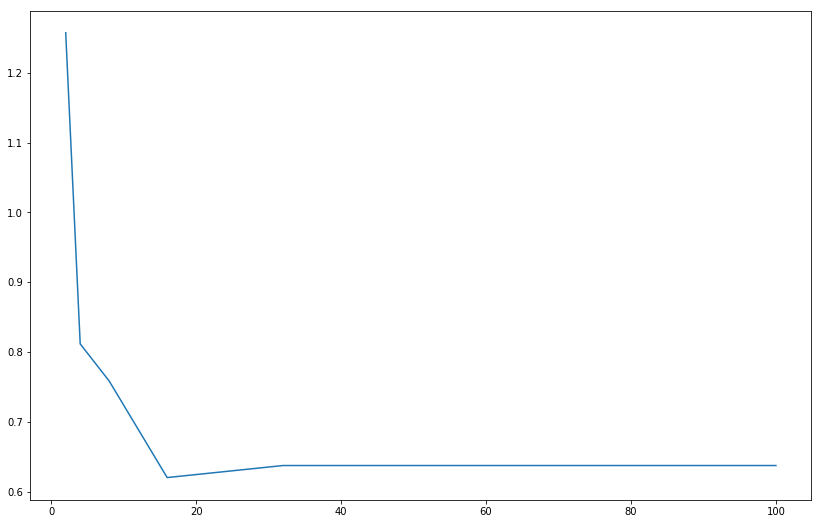

In [176]:
# Maximo de bins
params = [2, 4, 8, 16, 32, 64, 100]
metrics = [evaluate_dt(train_data_dt, test_data_dt, 5, param) for param in params]

print 'Parametros escolhidos:', params
print 'RMSLE dos parametros', metrics

plot(params, metrics)
fig = matplotlib.pyplot.gcf()

In [ ]:
# Save and load model
#model.save(sc, "home/myDecisionTreeClassificationModel")


In [ ]:
#sameModel = DecisionTreeModel.load(sc, "target/tmp/myDecisionTreeClassificationModel")